<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

_Authors: _

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [115]:
import matplotlib.pyplot as plt


%matplotlib inline
% matplotlib inline

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_boston
boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])
z= pd.concat([X,y], axis=1)
print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [54]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column


In [117]:
#type of data
 
print(type(boston))
print(type(z))


<class 'sklearn.datasets.base.Bunch'>
<class 'pandas.core.frame.DataFrame'>


In [119]:
#see sample of dataset

z.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [44]:
#get information on dataset

print z.index

print z.dtypes

print z.shape

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            496, 497, 498, 499, 500, 501, 502, 503, 504, 505],
           dtype='int64', length=1012)
AGE        float64
B          float64
CHAS       float64
CRIM       float64
DIS        float64
INDUS      float64
LSTAT      float64
MEDV       float64
NOX        float64
PTRATIO    float64
RAD        float64
RM         float64
TAX        float64
ZN         float64
dtype: object
(1012, 14)


In [57]:
#check for incomplete data

print(z.isnull().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


In [58]:
#summary statistics

z.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV and perform a 50/50 test-train split
Score and plot your predictions.

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

def train_test_rmse_50(df, feature_cols):
    X = df[feature_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=1234)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))


In [123]:
print train_test_rmse_50(z, ['AGE', 'CRIM', 'INDUS'])
print train_test_rmse_50(z, ['ZN', 'CHAS', 'NOX'])
print train_test_rmse_50(z, ['TAX', 'RAD', 'PTRATIO'])

7.71187139974
8.01057771055
7.36118486385


### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change?

In [93]:
def train_test_rmse_70(df, feature_cols):
    X = df[feature_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7,random_state=1234)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [98]:
print train_test_rmse_70(z, ['AGE', 'CRIM', 'INDUS'])
print train_test_rmse_70(z, ['ZN', 'CHAS', 'NOX'])
print train_test_rmse_70(z, ['TAX', 'RAD', 'PTRATIO'])

7.72769190541
7.99408017358
7.55696717298


In [100]:
def train_test_rmse_90(df, feature_cols):
    X = df[feature_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9,random_state=1234)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [101]:
print train_test_rmse_90(z, ['AGE', 'CRIM', 'INDUS'])
print train_test_rmse_90(z, ['ZN', 'CHAS', 'NOX'])
print train_test_rmse_90(z, ['TAX', 'RAD', 'PTRATIO'])

8.42566667886
8.43957697246
8.63619864969


### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score.

In [102]:
from sklearn import model_selection

In [103]:
kf = model_selection.KFold(n_splits=5, shuffle=True)

In [104]:
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)    

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 23.6479154658
R2: 0.739231879007
Model 2
MSE: 24.8546458936
R2: 0.739617635616
Model 3
MSE: 24.8860336042
R2: 0.739886919738
Model 4
MSE: 17.6285251131
R2: 0.738053953622
Model 5
MSE: 24.1687293907
R2: 0.738627070378
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 23.0371698935
Mean of R2 for all folds: 0.739083491672


In [105]:
kf = model_selection.KFold(n_splits=10, shuffle=True)

In [106]:
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores) 

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 11.85159576
R2: 0.740076162706
Model 2
MSE: 38.7767948802
R2: 0.739319615352
Model 3
MSE: 29.071708945
R2: 0.739598871463
Model 4
MSE: 14.1148728586
R2: 0.74005542756
Model 5
MSE: 30.2804889939
R2: 0.73975445842
Model 6
MSE: 20.4390405572
R2: 0.73908289517
Model 7
MSE: 13.8415785751
R2: 0.73987505089
Model 8
MSE: 17.7986844278
R2: 0.739042671173
Model 9
MSE: 28.3454522461
R2: 0.74007919465
Model 10
MSE: 29.8108100005
R2: 0.739425978156
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 23.4331027244
Mean of R2 for all folds: 0.739631032554


# KNN Practice

In [124]:
# Read the iris data into a DataFrame
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [125]:
iris.head()

# Allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [126]:
# Create a custom colormap
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [127]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'

iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})


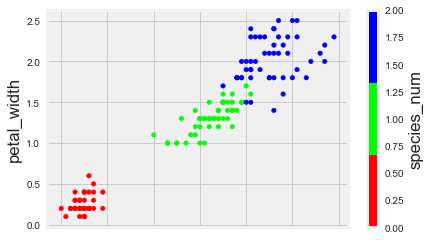

In [128]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES

iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap=cmap_bold);

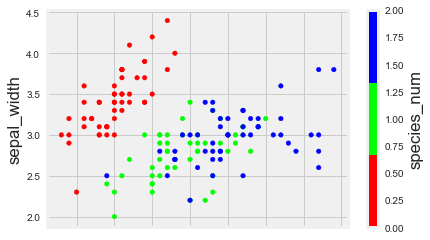

In [129]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES

iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap=cmap_bold);

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [153]:
# Create feature matrix (X).
feature_cols = ['petal_length', 'petal_width']
X = iris[feature_cols]

### Create your target vector "y"
This will be the species type.

In [154]:
# Create response vector (y).
y = iris.species_num

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=199)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [160]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [161]:
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.925


### Create a Model With Five Neighbors. Did it Improve?

In [164]:

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.933333333333


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

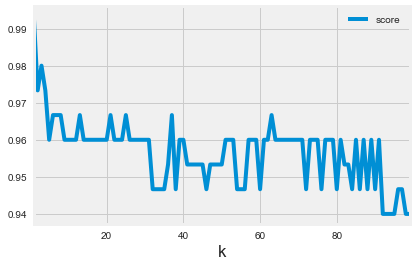

In [169]:
scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X,y)
    pred = knn.predict(X)
    score = float(sum(pred == y)) / len(y)
    scores.append([k, score])

data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score');

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [7]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [8]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf


# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

print result.summary()

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sat, 09 Sep 2017   Prob (F-statistic):          1.59e-321
Time:                        11:28:11   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.0

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [12]:
# Check out variable relations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [9]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [10]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [11]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print "R^2 Score: ", metrics.r2_score(y_test, predictions)

R^2 Score:  0.585401882653
